
Installation of gluonts + other libraries


In [4]:
#!pip install mxnet
pip install gluonts

     |████████████████████████████████| 419kB 2.7MB/s 
     |████████████████████████████████| 7.4MB 8.9MB/s 
     |████████████████████████████████| 194kB 46.8MB/s 
  Created wheel for ujson: filename=ujson-1.35-cp36-cp36m-linux_x86_64.whl size=68028 sha256=7e09fe9bdfbbd7817526d65adb57fcd045128ae32f47fd76c8c13d516affbe5d
  Stored in directory: /root/.cache/pip/wheels/28/77/e4/0311145b9c2e2f01470e744855131f9e34d6919687550f87d1
Successfully built ujson


In [5]:
pip install pydantic==1.4 #pip install pydantic==1.4

     |████████████████████████████████| 7.5MB 2.6MB/s 
  Found existing installation: pydantic 1.5.1
    Uninstalling pydantic-1.5.1:
      Successfully uninstalled pydantic-1.5.1


In [6]:
pip install python-dateutil==2.8.1

In [0]:
import gluonts
import mxnet

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [117]:
%cd '/content/gdrive/My Drive'


/content/gdrive/My Drive


In [0]:
tex = 'avgtexas_jan2020.csv'
tex_dataset = pd.read_csv(tex)

In [0]:
tex_dataset.head()
tex_dataset= tex_dataset.rename(columns={"realtime_lmp (avg) (ercot)": "iso"})

In [0]:
#normalize
normalized_tex = tex_dataset
texmax = tex_dataset['iso'].max()
texmin = tex_dataset['iso'].min()

normalized_tex['iso'] = (tex_dataset['iso'] - texmin)/(texmax - texmin)


In [0]:
"""import pandas as pd
caiso_url = 'https://raw.githubusercontent.com/sy2657/representation_learning/master/caiso_jan2020_systemloadresource_tacnorth.csv'
caiso_dataset = pd.read_csv(caiso_url)"""

In [0]:
caiso_dataset.head()

,DateTime,iso
0,2020-01-01 00:00:00,9282
1,2020-01-01 01:00:00,8912
2,2020-01-01 02:00:00,8678
3,2020-01-01 03:00:00,8549
4,2020-01-01 04:00:00,8540


In [0]:
caiso_dataset['DateTime'][0]

'2020-01-01 00:00:00'

Australian smart city dataset: 

In [0]:
import csv
row_num = 0

watts = []
time_stamps =[]

with open('CD_INTERVAL_READING_ALL_NO_QUOTES.csv', newline='') as csvfile:
  reader = csv.reader(csvfile, delimiter=' ')
  for row in reader:
    row_num = row_num+1
    #print(row[0])
    sdata = row[1]
    tsplit = sdata.split(',')
    if row_num==1:
      continue
    #print(row[1])
    #print(tsplit[3])
    ntsplit = float(tsplit[3])
    watts.append(ntsplit)
    time_stamps.append(tsplit[0])
    #print(row[2])
    #print(row[3])
    #print(row[4])
    if row_num > 80000:
      break

Part A: hierarchical time series on hierarchy given by region (in CA) 

In [0]:
import pandas as pd
# multiple regions
rfile = 'CaFeb2020DemandzonesCaNevpPace.csv'
reg_dataset = pd.read_csv(rfile) 

In [0]:
reg_dataset.head()

reg_dataset = reg_dataset.rename(columns={"demand_forecast (CA ISO-TAC) (california_iso)": "CAISOTAC", "demand_forecast (NEVP) (california_iso)":"NEVP", "demand_forecast (PACE) (california_iso)":"PACE"})


In [0]:
# bottom up procedure

In [0]:
# top down procedure
# proportions  : calculate avg proportion
ratio1 = 1 # CAISO : NEVP
ratio2 = 1 # CAISO: PACE
arrayratio1 = []
arrayratio2 = []

# top down: column with sum of other columns
columnsum=[]

for index, row in reg_dataset.iterrows():
  caisotac= row['CAISOTAC']
  nevp = row['NEVP']
  pace = row['PACE']
  arrayratio1.append(float(caisotac/nevp))
  arrayratio2.append(float(caisotac/pace))
  allthree= float(caisotac)+ float(nevp) + float(pace)
  columnsum.append(allthree)

reg_dataset['allsum'] = columnsum

#ratio1 = np.mean(arrayratio1)

In [0]:
# ratio for top down
import numpy as np
ratio1 = np.mean(arrayratio1)
ratio2 = np.mean(arrayratio2)

In [0]:
from gluonts.dataset.common import ListDataset

datetime0 = reg_dataset['DateTime'][0]
# train data sets 
# for topdown
regtraining = ListDataset(
    [{"start": datetime0, "target": reg_dataset.allsum.values}], freq = "1H")

# for bottom up 
caisotactraining = ListDataset(
    [{"start": datetime0, "target": reg_dataset.CAISOTAC.values}], freq = "1H")
nevptraining = ListDataset(
    [{"start": datetime0, "target": reg_dataset.NEVP.values}], freq = "1H")

pacetraining = ListDataset(
    [{"start": datetime0, "target": reg_dataset.PACE.values}], freq = "1H")


In [0]:

# test data sets 
# choose starting index and ending index
test1 = 100
test2 = 200
regtestdata =reg_dataset[test1:test2]

testdatetime0 = regtestdata['DateTime'][test1]

regtesting = ListDataset([{"start": testdatetime0, "target":regtestdata.allsum.values}], freq="1H")

caisotactesting = ListDataset([{"start": testdatetime0, "target":regtestdata.CAISOTAC.values}], freq="1H")
nevptesting =ListDataset([{"start": testdatetime0, "target":regtestdata.NEVP.values}], freq="1H")
pacetesting = ListDataset([{"start": testdatetime0, "target":regtestdata.PACE.values}], freq="1H")

In [25]:
ratio2

4.2572290368151915

In [0]:
# use model to predict and then aggregate (bottom up) / disaggregate (top down)

from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.trainer import Trainer

estimator_simple = SimpleFeedForwardEstimator(
    prediction_length = 30,
    context_length = 100,
    freq="1H",
    trainer= Trainer(ctx="cpu", epochs=5, learning_rate=1e-3, hybridize=True, num_batches_per_epoch=50)
)


In [26]:
# top down
# column with sum of other columns
predictor_simple = estimator_simple.train(regtraining) # training_data_caiso


  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:00<00:00, 139.80it/s, epoch=5/5, avg_epoch_loss=9.17]


In [27]:
# bottom up
predictor_simple1 = estimator_simple.train(caisotactraining) # training_data_caiso
predictor_simple2 = estimator_simple.train(nevptraining) # training_data_caiso

predictor_simple3 = estimator_simple.train(pacetraining) # training_data_caiso


  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:00<00:00, 144.68it/s, epoch=5/5, avg_epoch_loss=7.22]


In [0]:
from gluonts.evaluation.backtest import make_evaluation_predictions

forecast_sim, ts_sim = make_evaluation_predictions(dataset=regtesting, predictor=predictor_simple, num_samples=10)

In [0]:
# bottom up 
forecast_sim1, ts_sim1 = make_evaluation_predictions(dataset=caisotactesting, predictor=predictor_simple1, num_samples=10)

forecast_sim2, ts_sim2 = make_evaluation_predictions(dataset=nevptesting, predictor=predictor_simple2, num_samples=10)

forecast_sim3, ts_sim3 = make_evaluation_predictions(dataset=pacetesting, predictor=predictor_simple3, num_samples=10)


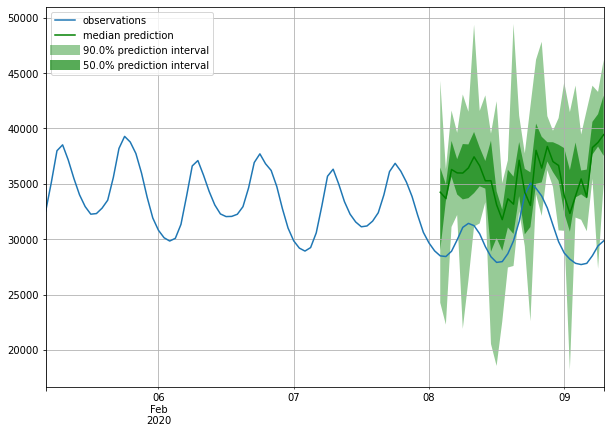

In [29]:
# top down
simforecasts= list(forecast_sim)
simtss = list(ts_sim)

sim_ts_entry = simtss[0]
sim_forecast_entry= simforecasts[0]

plot_prob_forecasts(sim_ts_entry, sim_forecast_entry)

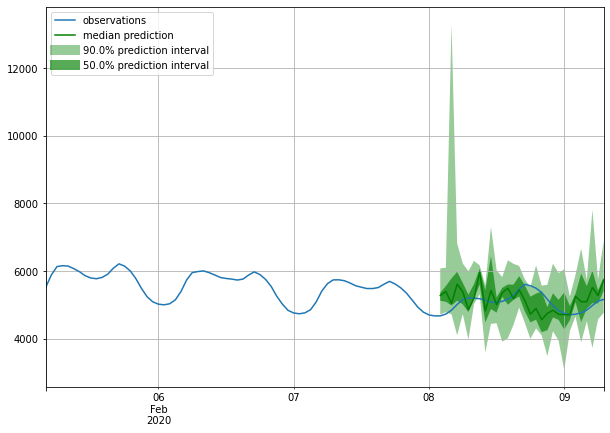

In [55]:
# bottom up

simforecasts1= list(forecast_sim3)
simtss1 = list(ts_sim3)

sim_ts_entry1 = simtss1[0]
sim_forecast_entry1 = simforecasts1[0]

plot_prob_forecasts(sim_ts_entry1, sim_forecast_entry1)


In [0]:
# top down: disaggregate using ratios

predicted30 = sim_forecast_entry.mean # 30 predicted values for test window of len 30 

# ratio for CAISOTAC
ratiocaisotac = 1- (1/ratio1 + 1/ratio2)
# ratio 1 -> CAISOTAC : NEVP
ratioNEVP = 1/ratio1
# ratio 2 -> CAISOTAC : PACE
ratioPACE = 1/ratio2

predicted30caisotac = predicted30*ratiocaisotac
predicted30Nevp = predicted30*ratioNEVP
predicted30Pace = predicted30*ratioPACE

In the following plot, the red is the total top prediction,
blue is the Caisotac prediction, green is the Nevp prediction, and orange is the Pace prediction. The Caisotac, Nevp, and Pace predictions were obtained using the top-down proportions calculated in the quantities ratio1, ratio2. 


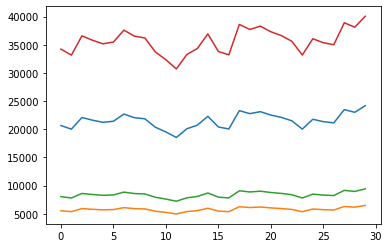

In [45]:
# plot 
import matplotlib.pyplot as plt
x = a = list(range(30))
plt.plot(x, predicted30caisotac)
plt.plot(x, predicted30Nevp)
plt.plot(x, predicted30Pace)
plt.plot(x, predicted30)

plt.show()


The following part involves wind and solar energy time series data from California and New England. The energy values are labeled by "iso" (changed column name) for convenience. 

Here, I have implemented 
- DeepAR Estimator
- simple feedforward network
- custom models: huber loss model, sampling of xpos, xneg from hourly divided series, triplet loss model 

I mainly perform tasks on datasets
- neweng_dataset 
- caiso_dataset 


In [0]:
# step 1
import pandas as pd
caisofile= 'CaisoJan19March19windsolarAvg.csv'
caiso_dataset = pd.read_csv(caisofile)

In [0]:
caiso_dataset.head()

,DateTime,ws_forecast (avg) (california_iso)
0,2019-01-01 00:00:00,-2.333
1,2019-01-01 01:00:00,-2.333
2,2019-01-01 02:00:00,-2.333
3,2019-01-01 03:00:00,-2.667
4,2019-01-01 04:00:00,-3.000


In [0]:
caiso_dataset2 = pd.read_csv('caiso_jan2020_systemloadresource_tacnorth.csv')


In [0]:
# ne step 1
import pandas as pd 
newengland = 'NewEnglandNov19WindSolar.csv'
neweng_dataset = pd.read_csv(newengland)

In [0]:
# step 1 b
caiso_dataset=caiso_dataset.rename(columns={"ws_forecast (avg) (california_iso)": "iso"})

# ne step 1 b
neweng_dataset =neweng_dataset.rename(columns={"ws_forecast (sum) (california_iso)": "iso"})


In [0]:
# ne step 1c : normalize 
normalized_neweng = neweng_dataset
# normalize new eng dataframe
ne_max = neweng_dataset['iso'].max()
#print(ne_max)
ne_min = neweng_dataset['iso'].min()
normalized_neweng['iso'] = (neweng_dataset['iso'] - ne_min)/(ne_max - ne_min)



In [0]:
# step 1 c
from gluonts.dataset.common import ListDataset

training_data_caiso = ListDataset(
    [{"start": "2019-01-01 00:00:00" , "target": caiso_dataset.iso.values}],
    freq = "1H"
)

# ne step 1 d: form training data

training_data_neweng = ListDataset([{"start":"2019-11-01 00:00:00", "target": neweng_dataset.iso.values
                                     }], freq = "1H")

# ne step 1 d: form training data

norm_training_data_neweng = ListDataset([{"start":"2019-11-01 00:00:00", "target": normalized_neweng.iso.values
                                     }], freq = "1H")

#norm_train_2_set = normalized_neweng[0:100]

#norm_training_data_neweng_2 = ListDataset([{"start":"2019-11-01 00:00:00", "target": norm_train_2_set.iso.values
#                                     }], freq = "1H")


# REQ: set test start and end indices
teststart = 100
testend = 150 

test_NE = neweng_dataset[teststart:testend]

norm_test_NE = normalized_neweng[teststart:testend]

In [0]:
# ADD TREND 
trend = np.zeros(len(neweng_dataset))

training_data_neweng2 = ListDataset([{"start":"2019-11-01 00:00:00", "target": neweng_dataset.iso.values, "feat_dynamic_real":trend}], freq="1H")


In [0]:
test_NE_dataset = ListDataset(
    [{"start": "2019-11-05 17:00:00" , "target": test_NE.iso.values}],
    freq = "1H"
)

norm_test_NE_dataset = ListDataset(
    [{"start": "2019-11-05 17:00:00" , "target": norm_test_NE.iso.values}],
    freq = "1H"
)


In [0]:
# Not required 

caiso_dataset2 =caiso_dataset2.rename(columns={"sys_load_rsrc (TAC_NORTH) (california_iso)": "iso"})
caiso_dataset2.head()
training_caiso2 = ListDataset(
    [{"start": "2020-01-01 00:00:00" , "target": caiso_dataset2.iso.values}],
    freq = "1H"
)

caiso_test_dataset = ListDataset(
    [{"start": "2020-01-05 04:00:00" , "target": test_caiso_3.iso.values}],
    freq = "1H"
)

pd random sampling rows: https://www.geeksforgeeks.org/how-to-randomly-select-rows-from-pandas-dataframe/


In [0]:
# step 1 d

# make a new dataframe for testing data ? 

# sample method 0: random; 
test_caiso_1 = caiso_dataset.sample(n = 30)  

# sample method 1 : sample every k rows; sample n cons. rows every k rows
k = 3
test_caiso_2 = caiso_dataset.iloc[::k, :]

test_caiso_3 = caiso_dataset[2:32]

train_caiso_2 = caiso_dataset[10:100]

# sample method 2: seasons / hour of day

# sample method 3: based on paper

# testing_data_caiso = ListDataset()

# step 1 f 
test_caiso_1_dataset = ListDataset(
    [{"start": "2019-02-07 09:00:00" , "target": test_caiso_1.iso.values}],
    freq = "1H"
)

test_caiso_3_dataset = ListDataset(
    [{"start": "2019-01-01 02:00:00" , "target": test_caiso_3.iso.values}],
    freq = "1H"
)
test_caiso_1 = caiso_dataset.sample(n = 300)  
test_caiso_1 

In [0]:
#import numpy as np
#np.random.randint(1, 8)
a = [1,2,3,4,5,6,7,8,9,0]
a[3:3+2]

# test the sampling

xr, xp, xn = sampling1(caiso_array, 20, 5)

# orig sampling method from unsupervised rep learning
def sampling1(y, N, K): # sequence y_i for i in 1 to N
  # size of y
  for i in range(1,N):
    yi = y[i]
    ysize = len(yi)
    # pick sizes s_pos and s_ref - unif at random 
    spos = np.random.randint(1, ysize)
    sref = np.random.randint(spos, ysize) 
    # pick xref, xpos 
    # pick starting index among 0 to (ysize - sref)
    startref = np.random.randint(0, ysize - sref)
    startpos = np.random.randint(0, ysize - spos)
    xref = yi[startref:startref+sref]
    xpos = yi[startpos:startpos+spos]
    xneg= []
    for k in range(1, K): 
      ik = np.random.randint(1, N)
      sneg = np.random.randint(1,len(y[ik]))
      # pick xneg
      startneg = np.random.randint(0, ysize-sneg)
      yk = y[k]
      xneg_k = yk[startneg:sneg]
      xneg.append(xneg_k)
    return( xref, xpos, xneg)

# sampling method var. 1: use different dist. other than uniform dist. to pick 


Hour hierarchical organization

In [0]:
# step 1 g 
# ne step 1 g : hierarchical order dataframes creation

# break the array into k sub-arrays : day of the week

# hour of the day: morning 6 am to 12 pm, afternoon 12 pm to 6 pm, evening 6 pm to 12 am, early morning 12 am to 6 am 

colnames=["DateTime", "iso"]
# define empty dfs 
morningdf = pd.DataFrame(columns=colnames)
afternoondf = pd.DataFrame(columns=colnames)
eveningdf = pd.DataFrame(columns= colnames)
earlymorningdf= pd.DataFrame(columns= colnames)

morning_time = []
morning_iso = []

afternoon_time = []
afternoon_iso = []

evening_time = []
evening_iso = []

earlymorning_time = []
earlymorning_iso = []

for index, row in normalized_tex.iterrows(): # normalized_neweng
    date_time = row['DateTime']
    iso_val = row['iso']
    split_date_time = date_time.split()
    split_date_time1 = split_date_time[1]
    hour_min_sec = split_date_time1.split(":")
    #print("hour min sec", hour_min_sec)
    hour= hour_min_sec[0]
    minute = hour_min_sec[1]   
    #print("hour", hour) 
    hour = float(hour)
    # determine zone
    if 0 <= hour <= 6:
      earlymorning_time.append(date_time)
      earlymorning_iso.append(iso_val)
    if 6 <= hour <=12:
      morning_time.append(date_time)
      morning_iso.append(iso_val)
    if 12 <= hour <= 18:
      afternoon_time.append(date_time)
      afternoon_iso.append(iso_val)
    if 18 <= hour <= 24:
      evening_time.append(date_time)
      evening_iso.append(iso_val)

# set dataframes

morningdf["DateTime"] = morning_time
morningdf["iso"] = morning_iso
earlymorningdf["DateTime"] = earlymorning_time
earlymorningdf["iso"]=earlymorning_iso
afternoondf["DateTime"] = afternoon_time
afternoondf["iso"] = afternoon_iso
eveningdf["DateTime"] = evening_time
eveningdf["iso"] = evening_iso

# use these as different series to draw xneg 


In [0]:
mtest = morningdf[100:130]
teststart = 36
testend = 42

mtest = morningdf[teststart:testend]
atest = afternoondf[teststart:testend]

etest = eveningdf[teststart:testend]

emtest = earlymorningdf[teststart:testend]


In [0]:
teststart = 50
testend = 70

mtest = morningdf[teststart:testend]

atest = afternoondf[teststart:testend]

etest = eveningdf[teststart:testend]

emtest = earlymorningdf[teststart:testend]


In [0]:
# step 1 g 2 
# extract the first timestamp from each series
morning_first_ts = morning_time[0]
earlymorning_first_ts= earlymorning_time[0]
afternoon_first_ts = afternoon_time[0]
evening_first_ts = evening_time[0]


In [0]:
# step 1 g 3
# convert x_neg into arrays

#earlymorningarray =earlymorningdf["iso"]

# arrays are called:

#earlymorning_iso
#afternoon_iso
#evening_iso

# step 1 h: set x_pos as one of the time zones, make into a dataset 

morningpos = ListDataset(
    [{"start":morning_first_ts , "target": morningdf.iso.values}],
    freq = "1H"
)

morningtrain = ListDataset(
    [{"start":morning_first_ts , "target": morningdf.iso.values}],
    freq = "1H"
)

In [0]:
afternoontrain = ListDataset(
[{"start":afternoon_first_ts , "target": afternoondf.iso.values}],
    freq = "1H"
)

earlymorningtrain = ListDataset(
    [{"start":earlymorning_first_ts , "target": earlymorningdf.iso.values}],
    freq = "1H"
)

In [0]:
# separately for texas

morningtrain = ListDataset(
    [{"start":morning_first_ts , "target": morningdf.iso.values}],
    freq = "5min"
)

afternoontrain = ListDataset(
[{"start":afternoon_first_ts , "target": afternoondf.iso.values}],
    freq = "5min"
)

earlymorningtrain = ListDataset(
    [{"start":earlymorning_first_ts , "target": earlymorningdf.iso.values}],
    freq = "5min"
)

eveningtrain = ListDataset([{"start":evening_first_ts , "target": eveningdf.iso.values}],
    freq = "5min")


In [0]:
#morningtest = ListDataset([{"start":"2019-11-16 06:00:00", "target":mtest.iso.values}], freq = "1H") # only have 6 consecutive entries 
morningtest = ListDataset([{"start":mtest["DateTime"][teststart], "target":mtest.iso.values}], freq = "1H")  

afternoontest = ListDataset([{"start":atest["DateTime"][teststart], "target": atest.iso.values}], freq="1H")

eveningtest = ListDataset([{"start":etest["DateTime"][teststart], "target": etest.iso.values}], freq="1H")
earlymorningtest = ListDataset([{"start":emtest["DateTime"][teststart], "target": emtest.iso.values}], freq="1H")


In [0]:
# texas test data

morningtest =  ListDataset([{"start":mtest["DateTime"][teststart], "target": mtest.iso.values}], freq="5min")
afternoontest = ListDataset([{"start":atest["DateTime"][teststart], "target": atest.iso.values}], freq="5min")

eveningtest = ListDataset([{"start":etest["DateTime"][teststart], "target": etest.iso.values}], freq="5min")
earlymorningtest = ListDataset([{"start":emtest["DateTime"][teststart], "target": emtest.iso.values}], freq="5min")



In [0]:
# step 1h 2 : set as evening
evening_train = ListDataset(
    [{"start":evening_first_ts , "target": eveningdf.iso.values}],
    freq = "1H"
)

In [0]:
import pandas as pd
# dataframe that holds ref, pos, and neg

# create df with col names
column_names = ["xref","xpos","xneg"]
triplet_dataframe = pd.DataFrame(columns = column_names)


In [0]:
# deepare on new england dataset 
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer
estimator = DeepAREstimator(freq="1H", prediction_length=30, trainer=Trainer(epochs=10,batch_size=10))
predictor = estimator.train(training_data= training_data_neweng ) # utraining, norm_training_data, norm_training_data_neweng

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


INFO:root:Number of parameters in DeepARTrainingNetwork: 27644
100%|██████████| 50/50 [00:02<00:00, 19.50it/s, avg_epoch_loss=8.5]
INFO:root:Epoch[0] Elapsed time 2.567 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.502146
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:02<00:00, 22.14it/s, avg_epoch_loss=7.59]
INFO:root:Epoch[1] Elapsed time 2.264 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.593466
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:02<00:00, 21.56it/s, avg_epoch_loss=7.32]
INFO:root:Epoch[2] Elapsed time 2.322 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.320614
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:02<00:00, 22.21it/s, avg_epoch_loss=7.12]
INFO:root:Epoch[3] Elapsed time 2.255 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.117959
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:02<00:00, 22.34it/s, avg_epoch_loss=6.94]
INFO:

In [75]:
# deepare LSTM
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer
estimator = DeepAREstimator(freq="1H", prediction_length=30, trainer=Trainer(epochs=10,batch_size=10), cell_type='lstm')
predictor = estimator.train(training_data= training_data_neweng ) 

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:02<00:00, 21.55it/s, epoch=10/10, avg_epoch_loss=-2.68]


In [0]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer
estimator = DeepAREstimator(freq="1H", prediction_length=30, trainer=Trainer(epochs=10,batch_size=10))
predictor = estimator.train(training_data=training_caiso2 )

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


INFO:root:Number of parameters in DeepARTrainingNetwork: 27644
100%|██████████| 50/50 [00:02<00:00, 19.78it/s, avg_epoch_loss=8.97]
INFO:root:Epoch[0] Elapsed time 2.530 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.973863
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:02<00:00, 21.73it/s, avg_epoch_loss=7.93]
INFO:root:Epoch[1] Elapsed time 2.302 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.928071
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:02<00:00, 21.40it/s, avg_epoch_loss=7.68]
INFO:root:Epoch[2] Elapsed time 2.339 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.678750
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:02<00:00, 21.85it/s, avg_epoch_loss=7.58]
INFO:root:Epoch[3] Elapsed time 2.293 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.576628
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:02<00:00, 21.74it/s, avg_epoch_loss=7.58]
INFO

In [0]:
# accuracy of deeparest. 
from gluonts.evaluation.backtest import make_evaluation_predictions
# caiso_test_dataset

deepare_forecast_it, deepare_ts_it = make_evaluation_predictions(dataset=caiso_test_dataset, 
                                                                 predictor=predictor, num_samples=10) # utesting, norm_test_NE_dataset

In [0]:
deepare_forecasts = list(deepare_forecast_it)
deepare_tss = list(deepare_ts_it)

In [0]:
# calc mean and quantiles 

dm = deepare_forecasts[0].mean

df = deepare_forecasts[0].quantile(0.5) 

In [0]:
dm

array([ 1.31618353e-11, -1.27344163e-10, -6.77906203e-11, -4.78871456e-11,
        1.34050228e-11, -3.06631387e-11, -1.52256228e-11, -3.41660485e-11,
       -7.60765340e-11, -7.01921021e-11, -1.23744709e-10, -1.57837042e-11,
       -3.42751522e-11, -5.61966931e-11, -9.18747439e-11, -1.12129653e-10,
       -4.11164644e-11,  1.21453845e-11, -7.64645638e-11, -2.09412113e-10,
       -8.81230505e-11, -6.54718640e-11, -3.97845958e-11, -5.55444787e-11,
       -1.48360185e-10,  5.01942758e-11,  1.87052249e-11, -6.16118892e-11,
       -1.55631202e-10, -8.42902553e-11], dtype=float32)

In [0]:
a = list(range(20,30))
a

[20, 21, 22, 23, 24, 25, 26, 27, 28, 29]

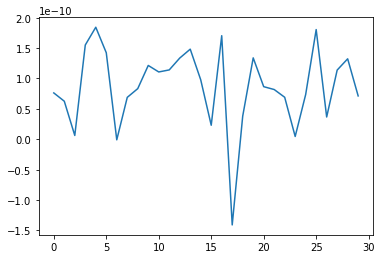

In [0]:
import matplotlib.pyplot as plt

a = list(range(30))
plt.plot( a, dm)
plt.show()

In [0]:
# record the time of test series 

# try to plot 


In [0]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.trainer import Trainer

estimator_simple = SimpleFeedForwardEstimator(
    prediction_length = 30,
    context_length = 100,
    freq="1H",
    trainer= Trainer(ctx="cpu", epochs=5, learning_rate=1e-3, hybridize=True, num_batches_per_epoch=50)
)

INFO:root:Using CPU


In [0]:
predictor_simple = estimator_simple.train(training_data_neweng) # training_data_caiso

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]INFO:root:Number of parameters in SimpleFeedForwardTrainingNetwork: 53363


learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:00<00:00, 120.30it/s, avg_epoch_loss=9]
INFO:root:Epoch[0] Elapsed time 0.420 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.995470
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 142.54it/s, avg_epoch_loss=8.27]
INFO:root:Epoch[1] Elapsed time 0.353 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=8.268792
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 151.88it/s, avg_epoch_loss=8.01]
INFO:root:Epoch[2] Elapsed time 0.334 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=8.007603
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 114.66it/s, avg_epoch_loss=7.85]
INFO:root:Epoch[3] Elapsed time 0.439 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.852622
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 151.42it/s, avg_epoch_loss=7.75]
INFO:root:Epoch[4] Elapsed time 0.333 seconds
INFO:root:Epoch[4] 

In [0]:
from gluonts.evaluation.backtest import make_evaluation_predictions
forecast_sim, ts_sim = make_evaluation_predictions(dataset=test_NE_dataset, predictor=predictor_simple, num_samples=10) # caiso_test_dataset

In [0]:
simforecasts= list(forecast_sim)
simtss = list(ts_sim)

In [0]:
sim_ts_entry = simtss[0]
sim_forecast_entry= simforecasts[0]

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


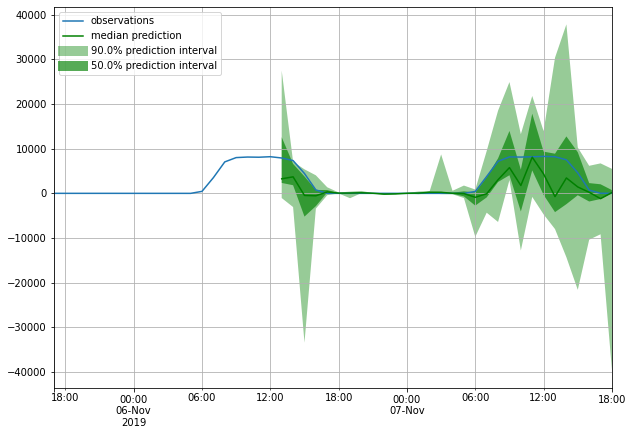

In [0]:
plot_prob_forecasts(sim_ts_entry, sim_forecast_entry)

In [0]:
sm = simforecasts[0].mean

In [0]:
sm

array([-6.3711592e-12,  4.9477627e-11,  2.2857116e-11,  6.5569009e-11,
        1.2326830e-10, -2.9853754e-12,  5.2458975e-11, -2.1367130e-11,
        7.2202687e-12,  3.5247399e-11,  2.6024891e-11,  2.0814170e-11,
        2.5721958e-11, -1.3999510e-12, -1.2954897e-11, -1.3925419e-11,
        1.7035595e-11,  2.7604382e-11, -2.8879562e-11, -5.6246717e-12,
       -1.9612503e-11,  7.4724454e-12, -4.7708136e-11, -4.9784499e-11,
        6.4138354e-11,  7.0450049e-11, -1.4262825e-11,  2.2299105e-11,
       -1.6318122e-11, -2.8550300e-12], dtype=float32)

In [0]:
simforecasts[0]

gluonts.model.forecast.SampleForecast(freq="1H", info=None, item_id=None, samples=numpy.array([[-1.8359766831843594e-11, 7.899934179045331e-12, 2.6523162138802903e-11, -7.867351518517363e-13, 2.5193375163823362e-11, 5.051912013720461e-11, 4.862155469909091e-11, 4.302871947636788e-11, -3.660967709540053e-11, 7.924452066765397e-11, 6.703438498734116e-11, -1.5475283554611252e-10, -3.676703472926812e-12, 1.7206185087825787e-10, 2.705581036988036e-10, 1.2122129688929562e-10, -5.633246299985295e-11, -1.3077360375146618e-11, -1.1234397093162762e-11, 4.377575385516863e-11, -4.069867706735231e-11, 1.3058223946593728e-10, -1.2966458462493335e-10, 7.692396524448808e-13, 5.8832214273885075e-12, 1.1408407551982691e-10, 5.80261463878351e-11, -2.81768445381525e-12, 5.113006892876193e-11, 2.2835495647188786e-11], [-4.9098294874205806e-11, -3.259488165485713e-11, 1.5977640044351205e-10, -2.830121900720961e-11, 2.933064555121767e-11, -9.039887761963517e-12, 6.386441375738627e-11, 5.964848059925032e-11, 

In [0]:
from gluonts.evaluation import Evaluator

evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(deepare_tss), iter(deepare_forecasts), num_series=len(norm_test_dataset))

Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 63.50it/s]


In [0]:
item_metrics.head()

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,sMAPE,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,NaN,0.199056,11.860371,11.860371,0.395346,NaN,NaN,2.0,NaN,2.372074,0.0,11.860371,0.0,21.348668,0.0


In [0]:
import matplotlib.pyplot as plt

def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0) # change the interval values 
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

In [0]:
d_ts_entry = deepare_tss[0]
d_forecast_entry= deepare_forecasts[0]

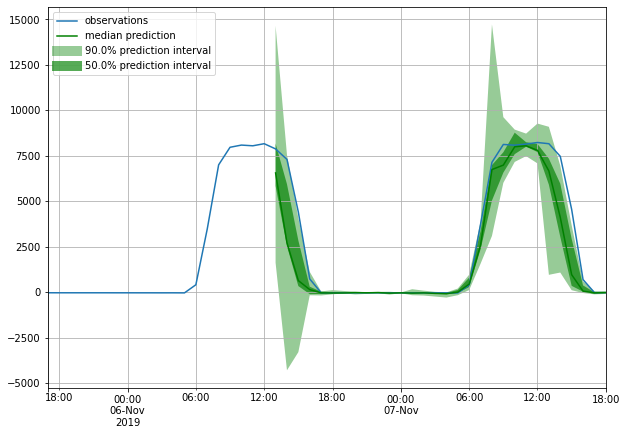

In [0]:
plot_prob_forecasts(d_ts_entry, d_forecast_entry)

In [0]:
len(train_ds1)

77000

gluon loss various functions 


In [0]:
import mxnet
from mxnet.gluon import nn, loss as gloss

import mxnet as mx
import mxnet.ndarray as nd
from mxnet import nd, autograd, gluon
from mxnet.gluon.data.vision import transforms

# L2 Loss
loss2 = gloss.L2Loss()

# sample data 
x = nd.ones((2,))
y = nd.ones((2,)) * 2
loss2(x, y)

# Huber loss
loss_huber = gloss.HuberLoss(rho=0.85) # threshold rho 

loss = gloss.SoftmaxCrossEntropyLoss()
x = nd.array([[1, 10], [8, 2]])
y = nd.array([0, 1])
loss(x, y)


[9.000123  6.0024757]
<NDArray 2 @cpu(0)>

In [0]:
xh = nd.array([1,2,3,4,5])
yh = nd.array([2,2,3,4,5])
loss_huber(xh, yh)


[0.575 0.    0.    0.    0.   ]
<NDArray 5 @cpu(0)>

In [0]:
# choose random x neg
import random
import numpy as np
# procedure to choose xneg by sampling from other subseries 


other_subseries = [morningdf, earlymorningdf, afternoondf] # when evening_train
other_subseries = [eveningdf, earlymorningdf, afternoondf] # when morning_train
other_subseries = [morningdf, eveningdf, afternoondf] # when earlymorningtrain
#other_subseries = [morningdf, earlymorningdf, eveningdf] # when afternoontrain

# choose one subseries at random
number_other = 3

def choose_xneg(alength): # returns array of length alength
    rand_num = random.randint(0, number_other-1)
    target_neg_df = other_subseries[rand_num]
    # sample of length alength
    negarray = np.array(target_neg_df['iso'])
    len_negarray = len(negarray)
    start = np.random.randint(0, len_negarray - alength)
    return negarray[start:start+alength]




In [0]:
# test above procedure
aneg = choose_xneg(10)

In [0]:
#from scipy.linalg import norm

# triplet loss compute
def compute_triplet_loss( xpos, xneg, pred):
  margin = 1
  array_len = len(xpos)
  tot = 0
  for i in range(0, array_len):

    ppos = pow(xpos[i] - pred[i], 2)
    pneg = pow(xneg[i]- pred[i], 2)
    
    addtotot= max(ppos - pneg + margin, 0)
    
    tot = tot+ max(ppos - pneg + margin, 0)

  return tot



In [0]:
compute_triplet_loss(apos,aneg, apred)

ppos 4
pneg 8.939782138254115
25.060217861745883
ppos 4
pneg 15.919675829032945
18.080324170967053
ppos 4
pneg 24.900722744822676
9.099277255177324
ppos 4
pneg 35.88084754260405
0
ppos 4
pneg 48.8125207866782
0
ppos 4
pneg 63.80601733040808
0
ppos 4
pneg 80.78175109514115
0
ppos 4
pneg 99.7597931392038
0
ppos 4
pneg 120.73829742397676
0
ppos 4
pneg 143.71726394946006
0


52.239819287890256

In [0]:
from mxnet.gluon.loss import TripletLoss

tloss = TripletLoss(margin=30)

from mxnet.gluon.loss import TripletLoss

tloss = TripletLoss(margin=10)

In [0]:
from mxnet import nd
tloss(nd.array(apred), nd.array(apos), nd.array(aneg))


[25.060219 18.080324  9.099279  0.        0.        0.        0.
  0.        0.        0.      ]
<NDArray 10 @cpu(0)>

custom_triplet_loss step 1

In [0]:

# custom step 1
from gluonts.model.estimator import GluonEstimator
from gluonts.model.predictor import Predictor, RepresentableBlockPredictor
from gluonts.core.component import validated
from gluonts.trainer import Trainer 
from gluonts.support.util import copy_parameters
from gluonts.transform import ExpectedNumInstanceSampler, Transformation, InstanceSplitter
from mxnet.gluon import HybridBlock 
from mxnet import gluon
from gluonts.dataset.field_names import FieldName

from mxnet.gluon import nn, loss as gloss
import mxnet as mx
import mxnet.ndarray as nd
from mxnet import nd, autograd, gluon
from mxnet.gluon.data.vision import transforms


In [0]:
# custom step 1 b
class MyNetwork(gluon.HybridBlock):
    def __init__(self, prediction_length, num_cells, **kwargs):
        super().__init__(**kwargs)
        self.prediction_length = prediction_length
        self.num_cells = num_cells
    
        with self.name_scope():
            # Set up a 4 layer neural network that directly predicts the target values
            self.nn = mx.gluon.nn.HybridSequential()
            self.nn.add(mx.gluon.nn.Dense(units=self.num_cells, activation='relu'))
            self.nn.add(mx.gluon.nn.Dense(units=self.num_cells, activation='relu'))
            self.nn.add(mx.gluon.nn.Dense(units=self.num_cells, activation='relu'))
            self.nn.add(mx.gluon.nn.Dense(units=self.prediction_length, activation='softrelu'))

class MyTrainNetwork1(MyNetwork):    
    def hybrid_forward(self, F, past_target, future_target): # add input 
        prediction = self.nn(past_target)
        # calculate L1 loss with the future_target to learn the median

        # change the loss 
        plen = len(prediction)

        print("len prediction is,", plen)
        #print("prediction is,", prediction)
        #print("future target is,", future_target)

        # change loss 
        # L2 loss

        loss2 = gloss.L2Loss()

        # huber loss
        
        #loss_huber = gloss.HuberLoss(rho=0.85)
        #hloss= loss_huber( nd.array(prediction), nd.array(future_target))

        # randomly choose xneg


        predlen = 20
        xneg = choose_xneg(predlen)

        # compare each sample with other (prediction and future target)
        array_trip_loss =[]
        for i in range(0, plen):
          pred_i = prediction[i]
          ft_i = future_target[i]
          triploss_i = compute_triplet_loss(ft_i, xneg, pred_i)
          array_trip_loss.append(triploss_i)

        #triploss= tloss(nd.array(future_target), nd.array(xneg), nd.array(prediction))

        #print("triplet loss:", triploss)
        
        #return (prediction - future_target).abs().mean(axis=-1)
        #print("hloss", hloss)
        #return hloss
        return array_trip_loss

class MyPredNetwork1(MyTrainNetwork1):
    # The prediction network only receives past_target and returns predictions
    def hybrid_forward(self, F, past_target):
        prediction = self.nn(past_target)
        return prediction.expand_dims(axis=1)

class MyEstimator1(GluonEstimator):
  @validated()
  def __init__(
      self,
      prediction_length:int,
      context_length:int,
      freq:str,
      num_cells:int,
      trainer: Trainer=Trainer()
  ) -> None:
      super().__init__(trainer=trainer)
      self.prediction_length = prediction_length
      self.context_length = context_length
      self.freq = freq
      self.num_cells = num_cells
  def create_transformation(self):
    return InstanceSplitter(
                    target_field=FieldName.TARGET,
                    is_pad_field=FieldName.IS_PAD,
                    start_field=FieldName.START,
                    forecast_start_field=FieldName.FORECAST_START,
                    train_sampler=ExpectedNumInstanceSampler(num_instances=1),
                    past_length=self.context_length,
                    future_length=self.prediction_length
                )
  def create_training_network(self) -> MyTrainNetwork1:
    return MyTrainNetwork1(
        prediction_length = self.prediction_length,
        num_cells= self.num_cells
    )
  def create_predictor(self, transformation:Transformation, trained_network: HybridBlock) -> Predictor:
    prediction_network = MyPredNetwork1(
        prediction_length= self.prediction_length,
        num_cells = self.num_cells
    )

    copy_parameters(trained_network, prediction_network)

    return RepresentableBlockPredictor(
        input_transform=transformation,
        prediction_net=prediction_network,
        batch_size = self.trainer.batch_size,
        freq = self.freq,
        prediction_length = self.prediction_length,
        ctx=self.trainer.ctx
    )

In [0]:
# probabilistic rnn -> covariates into it

In [141]:
# custom 1b -> next step 
# custom step 2 b

import mxnet as mx
pred_length = 20
estimator1 = MyEstimator1(prediction_length= pred_length, context_length=2*pred_length, freq="1H",num_cells=10, trainer=Trainer(ctx="cpu", epochs=5, learning_rate=1e-3, hybridize=False, num_batches_per_epoch=20))

predictor1 = estimator1.train(earlymorningtrain) # training_data_neweng

  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32


 80%|████████  | 16/20 [00:10<00:02,  1.54it/s, epoch=1/5, avg_epoch_loss=21.7]

len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32


  0%|          | 0/20 [00:00<?, ?it/s]

len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32


Exception ignored in: <bound method ParallelDataLoader.__del__ of <gluonts.dataset.parallelized_loader.ParallelDataLoader object at 0x7fc8037f9b00>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/gluonts/dataset/parallelized_loader.py", line 686, in __del__
    if self.worker_pool:
AttributeError: 'ParallelDataLoader' object has no attribute 'worker_pool'


len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32


 80%|████████  | 16/20 [00:10<00:02,  1.58it/s, epoch=2/5, avg_epoch_loss=22.7]

len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32


  0%|          | 0/20 [00:00<?, ?it/s]

len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32


 80%|████████  | 16/20 [00:10<00:02,  1.59it/s, epoch=3/5, avg_epoch_loss=23.3]

len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32


  0%|          | 0/20 [00:00<?, ?it/s]

len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32


 80%|████████  | 16/20 [00:10<00:02,  1.59it/s, epoch=4/5, avg_epoch_loss=23.8]

len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32


  0%|          | 0/20 [00:00<?, ?it/s]

len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32


 80%|████████  | 16/20 [00:10<00:02,  1.59it/s, epoch=5/5, avg_epoch_loss=21.3]

len prediction is, 32
len prediction is, 32
len prediction is, 32
len prediction is, 32


100%|██████████| 20/20 [00:12<00:00,  1.58it/s, epoch=5/5, avg_epoch_loss=21.3]


In [0]:
# step 3 b

from gluonts.evaluation.backtest import make_evaluation_predictions
#change test set to evening test set / morning test set
forecast_it, ts_it = make_evaluation_predictions(
    dataset=earlymorningtest,  # test dataset  norm_test_NE_dataset, test_NE_dataset
    predictor=predictor1,  # predictor
    num_samples=30,  # number of sample paths we want for evaluation
)

In [0]:
# step 3b new england

from gluonts.evaluation.backtest import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=norm_test_NE_dataset,  # test dataset; test_NE_dataset
    predictor=predictor1,  # predictor
    num_samples=30,  # number of sample paths we want for evaluation
)



In [0]:
# step 3b
forecasts = list(forecast_it)
tss = list(ts_it)

In [144]:
from gluonts.evaluation import Evaluator
# step 3b 2 metrics
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(earlymorningtest))

Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 27.50it/s]


In [145]:
item_metrics.head()

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,OWA,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,NaN,0.384775,12.403088,0.726022,0.036301,NaN,NaN,17.092646,1.790344,NaN,NaN,22.32556,1.0,12.403089,1.0,2.480618,1.0


In [0]:
d_triploss_ts_entry = tss[0]
d_triploss_forecast_entry= forecasts[0]

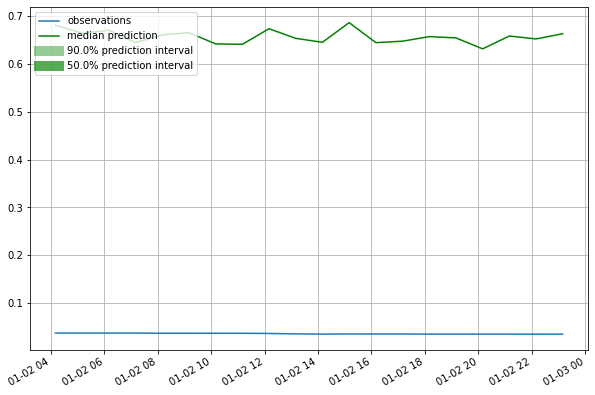

In [147]:
plot_prob_forecasts(d_triploss_ts_entry, d_triploss_forecast_entry)

In [0]:
# step 4 
# accuracy eval: MSE
import numpy as np
def root_mean_squared_error(y_true, y_pred):
  return np.sqrt(np.mean(np.square(y_pred - y_true)))

In [0]:
# step 4b plot forecasts

def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

In [0]:
# step 4c 
# metrics
from gluonts.evaluation import Evaluator

evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))


In [0]:
forecasts[0]
ts_entry = tss[0]

IndexError: ignored

After defining the training and prediction network, as well as the estimator class, we can follow exactly the same steps as with the existing models, i.e., we can specify our estimator by passing all the required hyperparameters to the estimator class, train the estimator by invoking its train method to create a predictor, and finally use the make_evaluation_predictions function to generate our forecasts.

In [0]:
from mxnet import gluon
from gluonts.model.estimator import GluonEstimator
from gluonts.model.predictor import Predictor, RepresentableBlockPredictor
from gluonts.trainer import Trainer
from gluonts.transform import InstanceSplitter, Transformation, ExpectedNumInstanceSampler
from gluonts.core.component import validated
from gluonts.support.util import copy_parameters 

#  gluonts.block.cnn.CausalConv1D 1D causal temporal convolution



class MyTrainNetwork(gluon.HybridBlock):

    def __init__(self, prediction_length, cells, act_type, **kwargs):

        super().__init__(**kwargs)

        self.prediction_length = prediction_length

        

        with self.name_scope():

            # set up a network that predicts the target

            #self.nn = mx.gluon.nn.HybridSequential()

            self.nn = gluon.nn.HybridSequential()    
            self.nn.add(gluon.nn.Dense(units=self.prediction_length, activation='relu'))
            self.nn.add(gluon.nn.Dense(units= 40, activation=act_type))
            self.nn.add(mx.gluon.nn.Dense(units=self.prediction_length, activation = 'softrelu'))    

    def hybrid_forward(self, F, past_target, future_target):

        prediction = self.nn(past_target)
        # calc L1 loss -> learn median
        return(prediction - future_target).abs().mean(axis=-1)

class MyPredNetwork(MyTrainNetwork):
    # The prediction network only receives past_target and returns predictions
    def hybrid_forward(self, F, past_target):
        prediction = self.nn(past_target)
        return prediction.expand_dims(axis=1)

try to write new estimator


In [0]:
class MyEstimator1(GluonEstimator):
    @validated()
    
    def __init__(
        self,
        freq: str,
        context_length: int,
        prediction_length: int,
        trainer: Trainer = Trainer()
    ) -> None:
        super().__init__(trainer=trainer)
        self.context_length = context_length
        self.prediction_length = prediction_length
        self.freq = freq


    def create_transformation(self):
        # Feature transformation that the model uses for input.
        # Here we use a transformation that randomly select training samples from all time series.
        return InstanceSplitter(
                    target_field=FieldName.TARGET,
                    is_pad_field=FieldName.IS_PAD,
                    start_field=FieldName.START,
                    forecast_start_field=FieldName.FORECAST_START,
                    train_sampler=ExpectedNumInstanceSampler(num_instances=1),
                    past_length=self.context_length,
                    future_length=self.prediction_length,
                )

    def create_training_network(self) -> MyTrainNetwork:
        return MyTrainNetwork(
            prediction_length=self.prediction_length
        )

    def create_predictor(
        self, transformation: Transformation, trained_network: HybridBlock
    ) -> Predictor:
        prediction_network = MyPredNetwork(
            prediction_length=self.prediction_length
        )

        copy_parameters(trained_network, prediction_network)

        return RepresentableBlockPredictor(
            input_transform=transformation,
            prediction_net=prediction_network,
            batch_size=self.trainer.batch_size,
            freq=self.freq,
            prediction_length=self.prediction_length,
            ctx=self.trainer.ctx,
        )

extended forecasting tutorial

https://github.com/awslabs/gluon-ts/blob/master/docs/examples/extended_forecasting_tutorial/extended_tutorial.md


In [0]:

# create artificial data sets

from gluonts.dataset.artificial._base import ComplexSeasonalTimeSeries
from gluonts.dataset.common import ListDataset

artificial_dataset = ComplexSeasonalTimeSeries(
    num_series=30,
    prediction_length=20,
    freq_str="H",
    length_low=30,
    length_high=200,
    min_val=-10,
    max_val=10000,
    is_integer=False,
    proportion_missing_values=0,
    is_noise=True,
    is_scale=True,
    percentage_unique_timestamps=1,
    is_out_of_bounds_date=True,
)

custom gluon model:

https://mxnet.apache.org/api/python/docs/tutorials/packages/gluon/blocks/save_load_params.html

https://beta.mxnet.io/api/gluon/_autogen/mxnet.gluon.loss.TripletLoss.html

https://mxnet.apache.org/api/python/docs/tutorials/packages/gluon/loss/loss.html

innovate : sampling algorithm 

In [0]:
from mxnet.gluon.loss import TripletLoss

In [0]:
import mxnet as mx

ModuleNotFoundError: ignored

In [0]:
x = mx.nd.array([1,0,1,0,1,0])
y = mx.nd.array([0,1,0,1,0,1])
z = mx.nd.array([2,1,2,1,2,1])
x1 = [0,0,0,0]
y1= [1,1,1,1]
z1 = [2,1,2,1]
label = mx.nd.array(-1)
triplet_loss = TripletLoss
print(triplet_loss(x1,y1,z1))
print(triplet_loss.summary)

NameError: ignored

In [0]:
import math

def sigmoid(x):
  return 1 / (1 + math.exp(-x))

def sigmoid_array(x):                                        
   return 1 / (1 + np.exp(-x))

mult_ratio = self.negative_penalty / self.nb_random_samples
#custom triplet loss

# Negative loss: -logsigmoid of minus the dot product between
# anchor and negative representations
def triplet_loss_foward(xref, xpos, xneg):
  # xneg has several samples 
  loss= - sigmoid(np.dot(xref, xpos))
  for i in range(num_random_samples):
    loss = loss+mult_ratio*np.mean(- sigmoid(np.dot(xref, xneg[i])))

In [0]:
#custom quadruplet loss 

In [0]:
# custom triplet loss function : beyond triplet loss: https://www.zpascal.net/cvpr2017/Chen_Beyond_Triplet_Loss_CVPR_2017_paper.pdf

# what does loss function do ? 

# choose loss function from : https://mxnet.apache.org/api/python/docs/tutorials/packages/gluon/loss/loss.html

# incorporate hierarchical struct into triplet loss ? 
#http://openaccess.thecvf.com/content_ECCV_2018/papers/Ge_Deep_Metric_Learning_ECCV_2018_paper.pdf

# hierarchical loss?

In [0]:
import mxnet 
from mxnet.symbol.contrib import ctc_loss

In [0]:
import mxnet as mx
x = mx.nd.array([1,0,1,0,1,0])
y = mx.nd.array([1,0,1,0,1,0])
ctc_loss(x,y)

AssertionError: ignored

In [0]:

# hybrid_forward(F, pred, positive, negative)
#triplet_loss.hybrid_forward()
from mxnet.gluon import nn, loss as gloss
x = mx.nd.array([1,0,1,0,1,0])
y = mx.nd.array([1,0,1,0,1,0])
label = mx.nd.array(1)
loss = gloss.CosineEmbeddingLoss()
print(loss(x,y,label))


[[0.]]
<NDArray 1x1 @cpu(0)>


try plugging in this loss to gluonts


In [0]:
import mxnet as mx
import mxnet.ndarray as nd
from mxnet import nd, autograd, gluon
from mxnet.gluon.data.vision import transforms

import numpy as np

def train_model(model):
  

In [0]:

# MNIST images are 28x28. Total pixels in input layer is 28x28 = 784
num_inputs = 784
# Clasify the images into one of the 10 digits
num_outputs = 10
# 64 images in a batch
batch_size = 64

# Load the training data
train_data = gluon.data.DataLoader(gluon.data.vision.MNIST(train=True).transform_first(transforms.ToTensor()),
                                   batch_size, shuffle=True)

# Build a simple convolutional network
def build_lenet(net):
    with net.name_scope():
        # First convolution
        net.add(gluon.nn.Conv2D(channels=20, kernel_size=5, activation='relu'))
        net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
        # Second convolution
        net.add(gluon.nn.Conv2D(channels=50, kernel_size=5, activation='relu'))
        net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
        # Flatten the output before the fully connected layers
        net.add(gluon.nn.Flatten())
        # First fully connected layers with 512 neurons
        net.add(gluon.nn.Dense(512, activation="relu"))
        # Second fully connected layer with as many neurons as the number of classes
        net.add(gluon.nn.Dense(num_outputs))

        return net

# Train a given model using MNIST data
def train_model(model):
    # Initialize the parameters with Xavier initializer
    model.collect_params().initialize(mx.init.Xavier(), ctx=ctx)
    # Use cross entropy loss
    softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
    # Use Adam optimizer
    trainer = gluon.Trainer(model.collect_params(), 'adam', {'learning_rate': .001})

    # Train for one epoch
    for epoch in range(1):
        # Iterate through the images and labels in the training data
        for batch_num, (data, label) in enumerate(train_data):
            # get the images and labels
            data = data.as_in_context(ctx)
            label = label.as_in_context(ctx)
            # Ask autograd to record the forward pass
            with autograd.record():
                # Run the forward pass
                output = model(data)
                # Compute the loss
                loss = softmax_cross_entropy(output, label)
            # Compute gradients
            loss.backward()
            # Update parameters
            trainer.step(data.shape[0])

            # Print loss once in a while
            if batch_num % 50 == 0:
                curr_loss = nd.mean(loss).asscalar()
                print("Epoch: %d; Batch %d; Loss %f" % (epoch, batch_num, curr_loss))

In [0]:
# custom step 1 c

from gluonts.distribution.distribution_output import DistributionOutput
from gluonts.distribution.gaussian import GaussianOutput



class MyProbNetwork(gluon.HybridBlock):
    def __init__(self,
                 prediction_length,
                 distr_output,
                 num_cells,
                 num_sample_paths=10,
                 **kwargs
    ) -> None:
        super().__init__(**kwargs)
        self.prediction_length = prediction_length
        self.distr_output = distr_output
        self.num_cells = num_cells
        self.num_sample_paths = num_sample_paths
        self.proj_distr_args = distr_output.get_args_proj()

        with self.name_scope():
            # Set up a 3 layer neural network that its ouput will be projected to the distribution parameters
            self.nn = mx.gluon.nn.HybridSequential()
            self.nn.add(mx.gluon.nn.Dense(units=self.num_cells, activation='relu'))
            self.nn.add(mx.gluon.nn.Dense(units=self.num_cells, activation='relu'))
            self.nn.add(mx.gluon.nn.Dense(units=self.prediction_length * self.num_cells, activation='relu'))


class MyProbTrainNetwork(MyProbNetwork):
    def hybrid_forward(self, F, past_target, future_target):
        # compute network output
        net_output = self.nn(past_target)

        # (batch, prediction_length * nn_features)  ->  (batch, prediction_length, nn_features)
        net_output = net_output.reshape(0, self.prediction_length, -1)

        # project network output to distribution parameters domain
        distr_args = self.proj_distr_args(net_output)

        #print("dist args,", distr_args)
        # compute distribution
        distr = self.distr_output.distribution(distr_args)

        # print dist
        #print("dist,", distr)
        # negative log-likelihood
        
        loss = distr.loss(future_target)
        #print("loss",loss)
        
        #xdistr = distr.

        # another loss 
        smloss = gloss.SoftmaxCrossEntropyLoss()
        sloss = smloss(loss, future_target)

        print("smlss", sloss)
        
        print("loss",loss)

        # KL div

        return loss


class MyProbPredNetwork(MyProbTrainNetwork):
    # The prediction network only receives past_target and returns predictions
    def hybrid_forward(self, F, past_target):
        # repeat past target: from (batch_size, past_target_length) to
        # (batch_size * num_sample_paths, past_target_length)
        repeated_past_target = past_target.repeat(
            repeats=self.num_sample_paths, axis=0
        )

        # compute network output
        net_output = self.nn(repeated_past_target)

        # (batch * num_sample_paths, prediction_length * nn_features)  ->  (batch * num_sample_paths, prediction_length, nn_features)
        net_output = net_output.reshape(0, self.prediction_length, -1)

        # project network output to distribution parameters domain
        distr_args = self.proj_distr_args(net_output)

        # compute distribution
        distr = self.distr_output.distribution(distr_args)

        # get (batch_size * num_sample_paths, prediction_length) samples
        samples = distr.sample()

        # reshape from (batch_size * num_sample_paths, prediction_length) to
        # (batch_size, num_sample_paths, prediction_length)
        return samples.reshape(shape=(-1, self.num_sample_paths, self.prediction_length))

class MyProbEstimator(GluonEstimator):
    @validated()
    def __init__(
            self,
            prediction_length: int,
            context_length: int,
            freq: str,
            distr_output: DistributionOutput,
            num_cells: int,
            num_sample_paths: int = 100,
            trainer: Trainer = Trainer()
    ) -> None:
        super().__init__(trainer=trainer)
        self.prediction_length = prediction_length
        self.context_length = context_length
        self.freq = freq
        self.distr_output = distr_output
        self.num_cells = num_cells
        self.num_sample_paths = num_sample_paths

    def create_transformation(self):
        return InstanceSplitter(
            target_field=FieldName.TARGET,
            is_pad_field=FieldName.IS_PAD,
            start_field=FieldName.START,
            forecast_start_field=FieldName.FORECAST_START,
            train_sampler=ExpectedNumInstanceSampler(num_instances=1),
            past_length=self.context_length,
            future_length=self.prediction_length,
        )

    def create_training_network(self) -> MyProbTrainNetwork:
        return MyProbTrainNetwork(
            prediction_length=self.prediction_length,
            distr_output=self.distr_output,
            num_cells=self.num_cells,
            num_sample_paths=self.num_sample_paths
        )

    def create_predictor(
            self, transformation: Transformation, trained_network: HybridBlock
    ) -> Predictor:
        prediction_network = MyProbPredNetwork(
            prediction_length=self.prediction_length,
            distr_output=self.distr_output,
            num_cells=self.num_cells,
            num_sample_paths=self.num_sample_paths
        )

        copy_parameters(trained_network, prediction_network)

        return RepresentableBlockPredictor(
            input_transform=transformation,
            prediction_net=prediction_network,
            batch_size=self.trainer.batch_size,
            freq=self.freq,
            prediction_length=self.prediction_length,
            ctx=self.trainer.ctx,
        )

INFO:root:Using CPU
